## Create sklearn decision tree

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
clf = DecisionTreeClassifier(random_state=0)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.6, shuffle=True)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [3]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
## This will create and export the decision tree as a pdf
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

'iris.pdf'

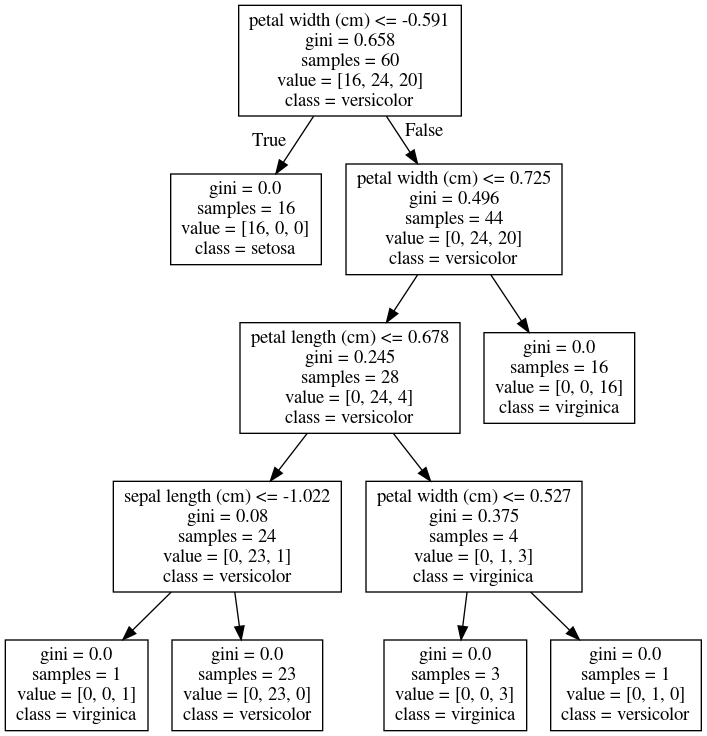

In [5]:
from IPython.display import Image  
from sklearn import tree
import pydotplus

dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=iris.feature_names,  
                                class_names=iris.target_names)

graph = pydotplus.graph_from_dot_data(dot_data)  

Image(graph.create_png())

In [6]:
print('left --    ',clf.tree_.children_left)
print('right --   ',clf.tree_.children_right)
print('features --',clf.tree_.feature)
print('threshold --', np.around(clf.tree_.threshold, 1))

left --     [ 1 -1  3  4  5 -1 -1  8 -1 -1 -1]
right --    [ 2 -1 10  7  6 -1 -1  9 -1 -1 -1]
features -- [ 3 -2  3  2  0 -2 -2  3 -2 -2 -2]
threshold -- [-0.6 -2.   0.7  0.7 -1.  -2.  -2.   0.5 -2.  -2.  -2. ]


## Data preparation

In [7]:
left_nodes = clf.tree_.children_left[clf.tree_.children_left>0]
right_nodes = clf.tree_.children_right[clf.tree_.children_right>0]
node_indicator = clf.decision_path(X)
path_list = []
for i, j in enumerate(X):
    path_list.append(node_indicator.indices[node_indicator.indptr[i]:node_indicator.indptr[i+1]])

## Convert path to strings
path_column = np.array([])
dec_feat_column = []
for i, j in enumerate(X):
    path_as_string = []
    dec_feat = []
    for node in path_list[i]:
        if node == 0:
            path_as_string.append('S')
            dec_feat.append(clf.tree_.feature[node]+1)
        elif node in left_nodes:
            path_as_string.append('L')
            if clf.tree_.feature[node] >= 0:
                dec_feat.append(clf.tree_.feature[node]+1)
            # else:
                # dec_feat.append(0)
        elif node in right_nodes:
            path_as_string.append('R')
            if clf.tree_.feature[node] >= 0:
                dec_feat.append(clf.tree_.feature[node]+1)
            # else:
                # dec_feat.append(0)
            
    path_as_string.append('E')
    dec_feat.append(0)
    dec_feat = np.array(dec_feat)
    path_as_string = ' '.join(path_as_string)
    path_column = np.append(path_column, path_as_string)
    dec_feat_column.append(dec_feat)

In [8]:
chars = ['S', 'L', 'R', 'E']
trimmed_chars = ['L', 'R', 'E']

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

trimmed_char_indices = dict((c, i) for i, c in enumerate(trimmed_chars))
trimmed_indices_char = dict((i, c) for i, c in enumerate(trimmed_chars))

Xnew = np.hstack((X, path_column.reshape(-1,1)))
path_sequence = Xnew[:,4]
data = pd.DataFrame(Xnew)
data[5] = y
data[6] = np.array(dec_feat_column)
# data = np.hstack((data, np.array(dec_feat_column).reshape(-1,1)))
# data = pd.DataFrame(data)
df = data.sample(frac=1).reset_index(drop=True)

# prepare dataset for training
get_path_lengths = lambda t: len(t.split())
paths_lengths = np.array([get_path_lengths(xi) for xi in path_sequence])

In [9]:
df.head()

,0,1,2,3,4,5,6
0,-0.1736739476359015,1.7095946507475455,-1.169714245881954,-1.18381211071744,S L E,0,"[4, 0]"
1,1.0380047568006114,-0.1319794793216258,0.7059208422669494,0.659038469346772,S R L R R E,1,"[4, 4, 3, 4, 0]"
2,-0.1736739476359015,-1.0527665443562113,-0.1466405614370976,-0.262386820685334,S R L L R E,1,"[4, 4, 3, 1, 0]"
3,0.6745011454696578,0.09821728693702086,0.9901079768349651,0.7906706536370729,S R R E,2,"[4, 4, 0]"
4,-0.1736739476359015,-0.1319794793216258,0.25122142695812444,0.0008775478952676988,S R L L R E,1,"[4, 4, 3, 1, 0]"


In [10]:
## Modified for decision feature prediction

vocab_size_feat = 5 # Or is it 4(should 0 be counted in)?
vocab_size_sent = 4
vocab_trimmed = 3
label_size = 3
feature_size = 4
# cut the text in semi-redundant sequences of maxlen characters
maxlen = np.max(paths_lengths)
maxlen_seq = maxlen-1

sentences = []
feat_seq = []
trimmed_path_seq = []
next_chars = []
next_dec_feature = []
next_trimmed_char = []
features = []
labels = []

for i in range(0, len(df)):
    # get the feature
    curr_feat = np.array([df.iloc[i,0:4]])
    # curr_feat_seq_len = len(curr_feat)
    curr_path = df.iloc[i,4].split()
    curr_path_len = len(curr_path)
    curr_label = y[i]
    curr_dec_feat = df.iloc[i, 6]
    curr_trimmed_path = [n for n in curr_path if n != 'S']
    for j in range(1,curr_path_len):
        features.append(curr_feat)
        labels.append(curr_label)
        sentences.append(curr_path[0:j])
        next_chars.append(curr_path[j])
    for k in range(1, len(curr_dec_feat)):
        next_dec_feature.append(curr_dec_feat[k])
        feat_seq.append(curr_dec_feat[0:k])
        trimmed_path_seq.append(curr_trimmed_path[0:k])
        next_trimmed_char.append(curr_trimmed_path[k])
print('Vectorization...')

x_sent = np.zeros((len(sentences), maxlen, vocab_size_sent), dtype=np.bool)
x_seq = np.zeros((len(feat_seq), maxlen_seq, vocab_size_feat), dtype=np.bool)
x_trimmed_sent = np.zeros((len(trimmed_path_seq), maxlen_seq, vocab_trimmed), dtype=np.bool)

x_feat = np.zeros((len(sentences), feature_size), dtype=np.float)
x_feat_seq = np.zeros((len(feat_seq), feature_size), dtype=np.float)

y_chars = np.zeros((len(sentences), vocab_size_sent), dtype=np.bool)
y_seq = np.zeros((len(feat_seq), vocab_size_feat), dtype=np.bool)
y_trimmed_chars = np.zeros((len(feat_seq), vocab_trimmed), dtype=np.bool)

y_feat = np.zeros((len(sentences), label_size), dtype=np.float)
y_feat_seq = np.zeros((len(feat_seq), label_size), dtype=np.float)

Vectorization...


In [11]:
sentences[0:10]
len(sentences)

508

In [12]:
next_chars[0:10]
len(next_chars)

508

In [13]:
feat_seq[0:10]
len(feat_seq)

358

In [14]:
next_dec_feature[0:10]
len(next_dec_feature)

358

In [15]:
trimmed_path_seq[0:10]
len(trimmed_path_seq)

358

In [16]:
next_trimmed_char[0:10]
len(next_trimmed_char)

358

In [17]:
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x_sent[i, t, char_indices[char]] = 1
    y_chars[i, char_indices[next_chars[i]]] = 1
    x_feat[i,:] = features[i]
    y_feat[i,labels[i]]=1
    
for i, feat in enumerate(feat_seq):
    for t, val in enumerate(feat):
        x_seq[i, t, val] = 1
    y_seq[i, next_dec_feature[i]] = 1
    x_feat_seq[i,:] = features[i]
    y_feat_seq[i,labels[i]]=1
    
for i, sentence in enumerate(trimmed_path_seq):
    for t, char in enumerate(sentence):
        x_trimmed_sent[i, t, trimmed_char_indices[char]] = 1
    y_trimmed_chars[i, trimmed_char_indices[next_trimmed_char[i]]] = 1

In [18]:
index = 10
print(y_chars[index],y_feat[index],x_sent[index],x_feat[index])
print(y_chars.shape,
      y_feat.shape,
      x_sent.shape,
      x_feat.shape)

[False False  True False] [1. 0. 0.] [[ True False False False]
 [False False  True False]
 [False  True False False]
 [False  True False False]
 [False False False False]
 [False False False False]] [-0.17367395 -1.05276654 -0.14664056 -0.26238682]
(508, 4) (508, 3) (508, 6, 4) (508, 4)


In [19]:
print(y_seq[index],y_feat_seq[index],x_seq[index],x_feat_seq[index])
print(y_seq.shape,
      y_feat_seq.shape,
      x_seq.shape,
      x_feat_seq.shape)

[ True False False False False] [1. 0. 0.] [[False False False False  True]
 [False False False False  True]
 [False False False False False]
 [False False False False False]
 [False False False False False]] [-0.17367395 -1.05276654 -0.14664056 -0.26238682]
(358, 5) (358, 3) (358, 5, 5) (358, 4)


In [20]:
print(y_trimmed_chars[index], x_trimmed_sent[index])
print(y_trimmed_chars.shape,
      x_trimmed_sent.shape)

[False False  True] [[False  True False]
 [False  True False]
 [False False False]
 [False False False]
 [False False False]]
(358, 3) (358, 5, 3)


## Model declaration and training

### Approach 1

In [ ]:
def paths_model(initialize=True, rnn_cell= 'gru',latent_dim = 5):
    from keras.models import Model
    from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Flatten, GRU
    latent_dim = latent_dim
    
    hidden_state_x = Input(shape=(latent_dim,),name='hidden_x')
    input_sent_features = Input(shape=(maxlen,vocab_size),name='ip_sent')
    # input_path/cutpoint/feat_features --> triplet tuple
    if rnn_cell == 'gru':
        RNN = GRU
    else:
        RNN = LSTM
            
    decoder = RNN(latent_dim,return_state=False,return_sequences=False,name='gru_sent')
    if initialize:
        decoder_outputs = decoder(input_sent_features,initial_state=hidden_state_x)
    else:
        decoder_outputs = decoder(input_sent_features)
    
    merge_layer = concatenate([hidden_state_x,decoder_outputs],name='cat')
    # concat -- All three with hidden_state_x
    output_chars = Dense(vocab_size, activation='softmax',name='op_sent')(merge_layer)
    model = Model([hidden_state_x,input_sent_features], output_chars)
    return model


def features_model(initialize=True, rnn_cell= 'gru',latent_dim = 5):
    from keras.models import Model
    from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Flatten, GRU
    latent_dim = latent_dim
    
    hidden_state_x = Input(shape=(latent_dim,),name='hidden_x')
    input_sent_features = Input(shape=(maxlen_seq,vocab_size),name='ip_sent')
    if rnn_cell == 'gru':
        RNN = GRU
    else:
        RNN = LSTM
            
    decoder = RNN(latent_dim,return_state=False,return_sequences=False,name='gru_sent')
    if initialize:
        decoder_outputs = decoder(input_sent_features,initial_state=hidden_state_x)
    else:
        decoder_outputs = decoder(input_sent_features)
    
    merge_layer = concatenate([hidden_state_x,decoder_outputs],name='cat')
    output_chars = Dense(vocab_size, activation='softmax',name='op_sent')(merge_layer)
    model = Model([hidden_state_x,input_sent_features], output_chars)
    return model

def label_model(feature_size = 4, latent_dim = 5):
    from keras.models import Model
    from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Flatten, GRU
    feature_size = feature_size
    h1_size = latent_dim
    input_x_features = Input(shape=(feature_size,),name='ip_x')
    hidden_state_x1 = Dense(20, activation='tanh',name='hidden_x1')(input_x_features)
    hidden_state_x2 = Dense(20, activation='tanh',name='hidden_x2')(hidden_state_x1)
    hidden_state_x3 = Dense(h1_size, activation='tanh',name='hidden_x3')(hidden_state_x2)
    output_labels = Dense(3, activation='softmax',name='op_x')(hidden_state_x3)    
    model = Model(input_x_features,output_labels)
    return model

from keras import backend as K

def get_hidden_x(x,model,layer_num=3):
    def get_hidden_x_inner(model,layer_num=layer_num):
        return K.function([model.layers[0].input], [model.layers[layer_num].output])
    return get_hidden_x_inner(model,layer_num=layer_num)([x])[0]

## Notes
# Multiple inputs multi outputs
# Hyperoptimization of loss weights(model.fit level) -- While clubbing into single model

### Aproach 2 -- feature model driven by paths as well

In [21]:
def paths_model(initialize=True, rnn_cell= 'gru',latent_dim = 5):
    from keras.models import Model
    from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Flatten, GRU
    latent_dim = latent_dim
    
    hidden_state_x = Input(shape=(latent_dim,),name='hidden_x')
    input_sent_features = Input(shape=(maxlen,vocab_size_sent),name='ip_sent')
    # input_path/cutpoint/feat_features --> triplet tuple
    if rnn_cell == 'gru':
        RNN = GRU
    else:
        RNN = LSTM
            
    decoder = RNN(latent_dim,return_state=False,return_sequences=False,name='gru_sent')
    if initialize:
        decoder_outputs = decoder(input_sent_features,initial_state=hidden_state_x)
    else:
        decoder_outputs = decoder(input_sent_features)
    
    merge_layer = concatenate([hidden_state_x,decoder_outputs],name='cat')
    # concat -- All three with hidden_state_x
    output_chars = Dense(vocab_size_sent, activation='softmax',name='op_sent')(merge_layer)
    model = Model([hidden_state_x,input_sent_features], output_chars)
    return model


def features_model(initialize=True, rnn_cell= 'gru',latent_dim = 5):
    from keras.models import Model
    from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Flatten, GRU
    latent_dim = latent_dim
    
    hidden_state_x = Input(shape=(latent_dim,),name='hidden_x')
    input_sent_features = Input(shape=(maxlen_seq,vocab_trimmed),name='ip_sent')
    input_seq_features = Input(shape=(maxlen_seq,vocab_size_feat),name='ip_seq')
    if rnn_cell == 'gru':
        RNN = GRU
    else:
        RNN = LSTM
            
    decoder_1 = RNN(latent_dim,return_state=False,return_sequences=False,name='gru_sent')
    decoder_2 = RNN(latent_dim,return_state=False,return_sequences=False,name='gru_seq')
    if initialize:
        decoder_outputs_1 = decoder_1(input_sent_features,initial_state=hidden_state_x)
        decoder_outputs_2 = decoder_2(input_seq_features,initial_state=hidden_state_x)
    else:
        decoder_outputs_1 = decoder_1(input_sent_features)
        decoder_outputs_2 = decoder_2(input_seq_features)
    
    merge_layer = concatenate([hidden_state_x,decoder_outputs_1, decoder_outputs_2],name='cat')
    output_chars = Dense(vocab_size_feat, activation='softmax',name='op_sent')(merge_layer)
    model = Model([hidden_state_x,input_sent_features, input_seq_features], output_chars)
    return model

def label_model(feature_size = 4, latent_dim = 5):
    from keras.models import Model
    from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Flatten, GRU
    feature_size = feature_size
    h1_size = latent_dim
    input_x_features = Input(shape=(feature_size,),name='ip_x')
    hidden_state_x1 = Dense(20, activation='tanh',name='hidden_x1')(input_x_features)
    hidden_state_x2 = Dense(20, activation='tanh',name='hidden_x2')(hidden_state_x1)
    hidden_state_x3 = Dense(h1_size, activation='tanh',name='hidden_x3')(hidden_state_x2)
    output_labels = Dense(3, activation='softmax',name='op_x')(hidden_state_x3)    
    model = Model(input_x_features,output_labels)
    return model

from keras import backend as K

def get_hidden_x(x,model,layer_num=3):
    def get_hidden_x_inner(model,layer_num=layer_num):
        return K.function([model.layers[0].input], [model.layers[layer_num].output])
    return get_hidden_x_inner(model,layer_num=layer_num)([x])[0]

Using TensorFlow backend.


In [22]:
path_m = paths_model()
path_m.summary()
label_m = label_model()
label_m.summary()
features_m = features_model()
features_m.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
hidden_x (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
ip_sent (InputLayer)            (None, 6, 4)         0                                            
__________________________________________________________________________________________________
gru_sent (GRU)                  (None, 5)            150         ip_sent[0][0]                    
                                                                 hidden_x[0][0]                   
__________________________________________________________________________________________________
cat (Concatenate)               (None

In [23]:
from keras.utils import to_categorical

y_cat = to_categorical(y)

label_m.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
label_m_history = label_m.fit(X,y_cat,batch_size =20, epochs = 200,verbose=0, shuffle=True)

x_latent = get_hidden_x(x_feat,model=label_m)

path_m.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
path_m.fit([x_latent,x_sent],y_chars,batch_size =20, epochs = 200,verbose=0, shuffle=True)

x_latent = get_hidden_x(x_feat_seq,model=label_m)

features_m.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
features_m.fit([x_latent,x_trimmed_sent,x_seq],y_seq,batch_size =20, epochs = 300,verbose=0, shuffle=True)

Instructions for updating:
Use tf.cast instead.


## Prediction/inference

In [24]:
from sklearn.metrics import jaccard_score, accuracy_score
import distance

latent_dim = 5

def jaccard_score_inconsistent(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)
def get_j_coeff(a,b):
    if len(a) != len(b):
        return jaccard_score_inconsistent(a, b)
    return jaccard_score(a, b, average='micro')
        

def sample_paths(x,path_model=path_m,label_model=label_m,latent_dim=latent_dim,feature_size=feature_size):
    n = x.shape[0]
    x_f = x.reshape(1,feature_size)
    token = 'S'
    feat_tok = df.iloc[0, 6][0] # Root node
    cont = True
    text = [token]
    seq = [feat_tok]
    # feat = []
    x_sent = np.zeros((1,maxlen,vocab_size_sent),dtype=np.bool)
    x_seq = np.zeros((1,maxlen_seq,vocab_size_feat),dtype=np.bool)
    x_trimmed_sent = np.zeros((1,maxlen_seq,vocab_trimmed),dtype=np.bool)
    x_latent = get_hidden_x(x_f,model=label_model)
    x_latent = x_latent.reshape(1,latent_dim)
    x_sent[0,0,char_indices[token]] = 1
    x_seq[0,0,feat_tok] = 1
    # x_seq[0,0,feat_tok] = 1
    pred = label_model.predict(x_f)
    label = [np.argmax(pred[0])]
    index = 1
    while cont & (index <maxlen):
        pred = path_model.predict([x_latent,x_sent])
        char_index = np.argmax(pred[0])
        x_sent[0,index,char_index] = 1
        next_char = indices_char[char_index]
        text.append(next_char)
        index += 1    
        if next_char == 'E':
            cont = False

    index = 1
    x_trimmed_sent[0, 0, trimmed_char_indices[text[1]]] = 1
    while (index < len(text)-1):
        pred_feat = features_m.predict([x_latent, x_trimmed_sent, x_seq])
        pred_val = np.argmax(pred_feat[0])
        x_seq[0,index,pred_val] = 1
        x_trimmed_sent[0, index, trimmed_char_indices[text[index+1]]] = 1
        next_val = pred_val
        seq.append(next_val)
        index += 1 
    return [text, label, seq]

# def predict_decision_feature(x, path_step)

count = []
j_coeff = []
j_coeff_feat = []
l_dist = []
pred_feat_list = []
pred_feat_accuracy = []
for i in range(150):
    curr_feat = np.array([df.iloc[i,0:4]])
    path, label, seq= sample_paths(curr_feat)
    print('actual vs predicted: ', df.iloc[i,4] ,' vs ', ' '.join(path), 'labels: ', df.iloc[i,5],label[0])
    count.append(df.iloc[i,5]==label[0])
    actual_path = df.iloc[i,4].split()
    actual_path_tok = [char_indices[char] for char in actual_path]
    pred_path_tok = [char_indices[char] for char in path]
    j_coeff.append(get_j_coeff(actual_path_tok, pred_path_tok))
    j_coeff_feat.append(get_j_coeff(df.iloc[i,6], seq))
    l_dist.append(distance.levenshtein(df.iloc[i,4].replace(' ', ''), ''.join(path)))
    
    print('Actual vs predicted features: ',df.iloc[i,6], 'vs', seq,'\n')
    

print('\nLabel accuracy - ',np.mean(count))
print('Path metric (Jaccard) - ',np.mean(j_coeff))
print('Path metric (Levensthein) - ',np.mean(l_dist))
print('Decision feature metric (Jaccard) - ',np.mean(j_coeff_feat))

actual vs predicted:  S L E  vs  S L E labels:  0 0
Actual vs predicted features:  [4 0] vs [4, 0] 

actual vs predicted:  S R L R R E  vs  S R L L R E labels:  1 1
Actual vs predicted features:  [4 4 3 4 0] vs [4, 4, 3, 1, 0] 

actual vs predicted:  S R L L R E  vs  S R L L R E labels:  1 1
Actual vs predicted features:  [4 4 3 1 0] vs [4, 4, 3, 1, 0] 

actual vs predicted:  S R R E  vs  S R R E labels:  2 2
Actual vs predicted features:  [4 4 0] vs [4, 4, 0] 

actual vs predicted:  S R L L R E  vs  S R L L R E labels:  1 1
Actual vs predicted features:  [4 4 3 1 0] vs [4, 4, 3, 1, 0] 

actual vs predicted:  S L E  vs  S L E labels:  0 0
Actual vs predicted features:  [4 0] vs [4, 0] 

actual vs predicted:  S L E  vs  S L E labels:  0 0
Actual vs predicted features:  [4 0] vs [4, 0] 

actual vs predicted:  S R R E  vs  S R R E labels:  2 2
Actual vs predicted features:  [4 4 0] vs [4, 4, 0] 

actual vs predicted:  S R R E  vs  S R R E labels:  2 2
Actual vs predicted features:  [4 4 0

actual vs predicted:  S R L L R E  vs  S R L L R E labels:  1 1
Actual vs predicted features:  [4 4 3 1 0] vs [4, 4, 3, 1, 0] 

actual vs predicted:  S R L L R E  vs  S R L L R E labels:  1 1
Actual vs predicted features:  [4 4 3 1 0] vs [4, 4, 3, 1, 0] 

actual vs predicted:  S R L L R E  vs  S R L L R E labels:  1 1
Actual vs predicted features:  [4 4 3 1 0] vs [4, 4, 3, 1, 0] 

actual vs predicted:  S L E  vs  S L E labels:  0 0
Actual vs predicted features:  [4 0] vs [4, 0] 

actual vs predicted:  S L E  vs  S L E labels:  0 0
Actual vs predicted features:  [4 0] vs [4, 0] 

actual vs predicted:  S L E  vs  S L E labels:  0 0
Actual vs predicted features:  [4 0] vs [4, 0] 

actual vs predicted:  S R R E  vs  S R R E labels:  2 2
Actual vs predicted features:  [4 4 0] vs [4, 4, 0] 

actual vs predicted:  S R R E  vs  S R R E labels:  2 2
Actual vs predicted features:  [4 4 0] vs [4, 4, 0] 

actual vs predicted:  S L E  vs  S L E labels:  0 0
Actual vs predicted features:  [4 0] vs [

actual vs predicted:  S R R E  vs  S R R E labels:  2 2
Actual vs predicted features:  [4 4 0] vs [4, 4, 0] 

actual vs predicted:  S R L L R E  vs  S R L L R E labels:  1 1
Actual vs predicted features:  [4 4 3 1 0] vs [4, 4, 3, 1, 0] 

actual vs predicted:  S R L L R E  vs  S R L L R E labels:  1 1
Actual vs predicted features:  [4 4 3 1 0] vs [4, 4, 3, 1, 0] 


Label accuracy -  0.9866666666666667
Path metric (Jaccard) -  0.9845238095238096
Path metric (Levensthein) -  0.08666666666666667
Decision feature metric (Jaccard) -  0.9777777777777777


Optimizations required

1) Path comparison - dt vs rnn output  -- Jaccard coeff/ levenstein distance (try both
2) cutpoints while training  -- feature information
   - Predict the precise cutpoint(regression model) 
   - 3 buckets(low, med, high)--range quantile splits1/3,2/3 -- Classification model
   - 4 classification models - 
3) Packaging it as a usable API  
4) latent_dim as hyperparam - ray/tune  
5) Test/train split. Validation

Tests
---

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, concatenate, Flatten, GRU

feature_size = 4
h1_size = 5
input_x_features = Input(shape=(feature_size,),name='ip_x')
hidden_state_x1 = Dense(20, activation='tanh',name='hidden_x1')(input_x_features)
hidden_state_x2 = Dense(10, activation='tanh',name='hidden_x2')(hidden_state_x1)
hidden_state_x3 = Dense(h1_size, activation='tanh',name='hidden_x3')(hidden_state_x2)
output_labels = Dense(3, activation='softmax',name='op_x')(hidden_state_x3)    
model = Model(input_x_features,output_labels)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(X,y_cat,batch_size =30, epochs = 200,verbose=1, shuffle=True)

In [ ]:
model.evaluate(X, y_cat)

In [ ]:
## Jaccard coeff trials

from sklearn.metrics import jaccard_score

from scipy.spatial import distance
distance.jaccard([1, 0, 0, 1], [0, 1, 0])


In [ ]:
# Model to predict decision feature

np.array([[[1,0],[0,0,0,1],[0,1,0]],
          [[1,0],[0,0,0,1],[0,1,0]]]).shape

In [ ]:
## Trial model -- to predict decision features
from keras.layers import Input, Dense
from keras.models import Model

input_1 = Input(shape=(5,))
hidden_1 = Dense(8, activation='tanh')(input_1)
output = Dense(5, activation='softmax')(hidden_1)

test_model = Model(input_1, output)

test_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
test_model.summary()

In [ ]:
chars = ['S', 'L', 'R', 'E']
char_indices = dict((c, i) for i, c in enumerate(chars))

for i, j in enumerate(final_test_df.values):
    final_test_df[5][i] = char_indices[final_test_df[5][i]]

In [ ]:
final_test_df = final_test_df.drop(columns=4)

trial_x = final_test_df.iloc[:,0:5]
trial_y = final_test_df.iloc[:,5]

# np.append(converted_chars, char_indices[final_test_df[5][i]])

In [ ]:
final_test_df.head(20)

In [ ]:
final_test_df.shape

In [ ]:
final_test_df[200:210]

In [ ]:
from keras.utils import to_categorical

trial_y = to_categorical(trial_y)

In [ ]:
trial_y.shape

In [ ]:
test_model.fit(trial_x, trial_y, batch_size =100, epochs = 1000,verbose=1, shuffle=True)

### Cutpoint trials

In [ ]:
x_4 = df.iloc[:,4]

x_4[0].split()[1]
x = x_4.apply(lambda temp:temp.split()[1])
w = df.iloc[:,3]

a = -100
b = 100
for i, val in enumerate(x):
    if val is 'L':
        a = max(a,float(w[i]))
    else:
        b = min(b,float(w[i]))
print('last -- ',a,b)

In [1]:
from keras.layers import RNN

Using TensorFlow backend.


In [10]:
a = [['S', 'R', 'L', 'L', 'E'], ['S', 'R', 'L', 'E']]

# x = [n for n in a if n != 'S' and n != 'E']

In [11]:
lengths = [len(xi) for xi in a]

In [12]:
lengths

[5, 4]